# Tensorflow Lite examples

Install tensorflow 2 (check the proper version to install [here](https://www.tensorflow.org/install/pip))

In [1]:
!pip install tensorflow-gpu > /dev/null

ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.1 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.1 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.6.3 which is incompatible.


In [0]:
!pip install "tensorflow_hub>=0.6.0" > /dev/null

In [35]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import numpy as np

import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

print(f"Tensorflow version {tf.__version__}")

Tensorflow version 2.0.0


## Converting models into Tensorflow Lite

### Example 1: converting saved models

Get some data for the equation y = x - 1

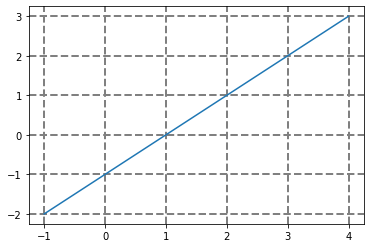

In [7]:
x = [-1, 0, 1, 2, 3, 4]
y = [-2, -1, 0, 1, 2, 3]
plt.plot(x, y)
plt.grid(color='gray', linestyle='--', linewidth=2)

Create a one layer keras model that will learn predicting y from x (i.e. a regression task)

In [8]:
layers = [tf.keras.layers.Dense(1, input_shape=[1])]
model = tf.keras.models.Sequential(layers)
model.compile('sgd', loss='mean_squared_error')
model.fit(x, y, epochs=100)

Train on 6 samples
Epoch 1/100
6/6 [==============================] - 1s 187ms/sample - loss: 1.6269
Epoch 2/100
6/6 [==============================] - 0s 3ms/sample - loss: 1.4185
Epoch 3/100
6/6 [==============================] - 0s 2ms/sample - loss: 1.2517
Epoch 4/100
6/6 [==============================] - 0s 2ms/sample - loss: 1.1176
Epoch 5/100
6/6 [==============================] - 0s 2ms/sample - loss: 1.0094
Epoch 6/100
6/6 [==============================] - 0s 2ms/sample - loss: 0.9217
Epoch 7/100
6/6 [==============================] - 0s 2ms/sample - loss: 0.8500
Epoch 8/100
6/6 [==============================] - 0s 2ms/sample - loss: 0.7910
Epoch 9/100
6/6 [==============================] - 0s 2ms/sample - loss: 0.7421
Epoch 10/100
6/6 [==============================] - 0s 2ms/sample - loss: 0.7012
Epoch 11/100
6/6 [==============================] - 0s 2ms/sample - loss: 0.6666
Epoch 12/100
6/6 [==============================] - 0s 2ms/sample - loss: 0.6370
Epoch 13/100
6/6

Check how well the model is behaving

In [9]:
model.predict(x)

array([[-1.4738147 ],
       [-0.6021444 ],
       [ 0.26952595],
       [ 1.1411963 ],
       [ 2.0128667 ],
       [ 2.884537  ]], dtype=float32)

Save the model

In [13]:
tf.saved_model.save(model, './output')

INFO:tensorflow:Assets written to: ./output/assets


Convert the model into TF Lite using `from_saved_model`

In [0]:
converter = tf.lite.TFLiteConverter.from_saved_model('./output')
tflite_model = converter.convert()

The output of the conversion is a byte array representing the model, let's store for future use

In [0]:
tflite_model_file = Path("./model.tflite")
open(tflite_model_file, 'wb').write(tflite_model)

Let's check how the new TF Lite model is behaving

In [17]:
tflite_model

b'\x1c\x00\x00\x00TFL3\x00\x00\x12\x00\x1c\x00\x04\x00\x08\x00\x0c\x00\x10\x00\x14\x00\x00\x00\x18\x00\x12\x00\x00\x00\x03\x00\x00\x00\xd0\x02\x00\x00\x10\x00\x00\x00\x1c\x00\x00\x00,\x00\x00\x00\x0c\x00\x00\x00\x01\x00\x00\x00\xb0\x00\x00\x00\x01\x00\x00\x00x\x00\x00\x00\x0f\x00\x00\x00TOCO Converted.\x00\x06\x00\x00\x00L\x00\x00\x00@\x00\x00\x00,\x00\x00\x00\x1c\x00\x00\x00\x10\x00\x00\x00\x04\x00\x00\x00\xda\xff\xff\xff4\x00\x00\x00\x94\xfd\xff\xff\x04\x00\x06\x00\x04\x00\x00\x00\x00\x00\x06\x00\n\x00\x04\x00\x06\x00\x00\x00\x88\x01\x00\x00\x00\x00\x06\x00\x08\x00\x04\x00\x06\x00\x00\x00\xec\x01\x00\x00\xc0\xfd\xff\xff\x05\x00\x00\x001.5.0\x00\x00\x00h\xff\xff\xff\x08\x00\x00\x00\x05\x00\x00\x00\x13\x00\x00\x00min_runtime_version\x00\x0c\x00\x14\x00\x04\x00\x08\x00\x0c\x00\x10\x00\x0c\x00\x00\x00 \x00\x00\x00\x14\x00\x00\x00\x08\x00\x00\x00\xa0\x01\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x03\x00\x00\x00\x04\x00\x00\x00d\x00\x00\x00\x94\x00\x00\x00\x1c\x01\x00\x00\x04

### Example 2: converting Keras models

Let's use a pretrained Keras model from Tensorlfow Hub, e.g. [MobileNet](https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4)

In [0]:
module_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
# use the model as a backbone for finetunning
backbone = hub.KerasLayer(module_url)
backbone.build([None, 224, 224, 3])

Let's fine tune this model on a small dataset (you can pick anyone from [Datasets Catalog](https://www.tensorflow.org/datasets/catalog/overview))

In [6]:
samples, info = tfds.load("caltech101", with_info=True)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset caltech101 downloaded and prepared to /root/tensorflow_datasets/caltech101/1.1.0. Subsequent calls will reuse this data.


In [7]:
print(info)

tfds.core.DatasetInfo(
    name='caltech101',
    version=1.1.0,
    description='Caltech-101 consists of pictures of objects belonging to 101 classes, plus
one `background clutter` class. Each image is labelled with a single object.
Each class contains roughly 40 to 800 images, totalling around 9k images.
Images are of variable sizes, with typical edge lengths of 200-300 pixels.
This version contains image-level labels only. The original dataset also
contains bounding boxes.
',
    urls=['http://www.vision.caltech.edu/Image_Datasets/Caltech101/'],
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=102),
    }),
    total_num_examples=9801,
    splits={
        'test': 6741,
        'train': 3060,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{FeiFei2004LearningGV,
      title={Learning Generative 

In [0]:
classes = info.features["label"].names

In [0]:
train_samples, test_samples = samples['train'], samples['test']

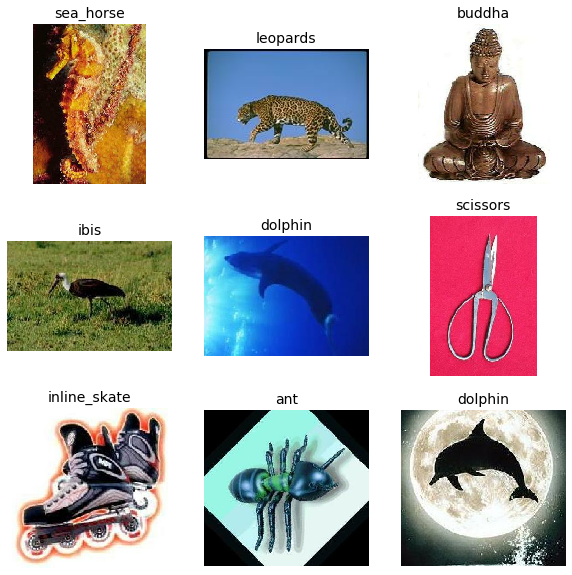

In [23]:
f = plt.figure(figsize=(10, 10))
for index, elem in enumerate(train_samples.take(9)):
  image, label_index = elem["image"], elem["label"].numpy()
  sp = f.add_subplot(3, 3, index + 1)
  sp.axis('off')
  sp.set_title(classes[label_index], fontsize=14)
  plt.imshow(image.numpy())

In [0]:
def normalize(row):
    image, label = row['image'], row['label']
    image = tf.dtypes.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = image / 255.0
    return image, label

In [0]:
train_data = train_samples.repeat().shuffle(1024).map(normalize).batch(32).prefetch(1)
test_data = test_samples.map(normalize).batch(1)

In [0]:
model = tf.keras.Sequential([backbone, tf.keras.layers.Dense(len(classes), activation='softmax')])
model.compile('adam', loss='sparse_categorical_crossentropy')

In [31]:
model.fit_generator(train_data, epochs=1, steps_per_epoch=100)

100/100 [==============================] - 57s 568ms/step - loss: 2.0983


After fine tuning the model, we can now convert it to TF Lite

In [0]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

Now we can save the TF Lite model for later use

In [33]:
tflite_model_file = './mobilenet_v2_caltech101.tflite'
open(tflite_model_file, 'wb').write(tflite_model)

9392900

Use a local interpreter to load the converted model

In [0]:
tflite_model_file = 'mobilenet_v2_caltech101.tflite'
with open(tflite_model_file, 'rb') as fid:
  tflite_model = fid.read()
  
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

Run the converted model against test data

In [41]:
predictions = []

test_labels, test_imgs = [], []
for image, label in tqdm(test_data.take(10)):
  interpreter.set_tensor(input_index, image)
  interpreter.invoke()
  predictions.append(interpreter.get_tensor(output_index))
  
  test_labels.append(label.numpy()[0])
  test_imgs.append(image)

10it [00:00, 11.81it/s]


Plot result

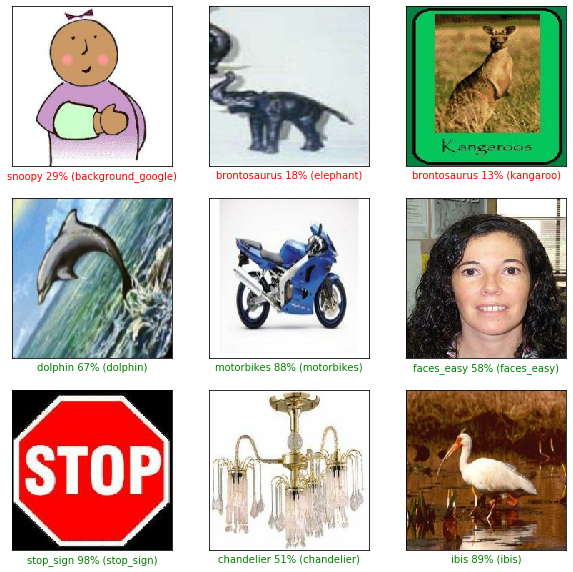

In [46]:
plt.figure(figsize=(10,10))
for (i, (predictions_array, true_label, image)) in enumerate(zip(predictions[:9], test_labels[:9], test_imgs[:9])):
  plt.subplot(3, 3, i+1)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
    
  image = np.squeeze(image)

  plt.imshow(image, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'green'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(classes[predicted_label],
                                100*np.max(predictions_array),
                                classes[true_label]),
                                color=color)
plt.show()

Pretty good, isn't?

### Example 3: converting concrete functions

In [70]:
model = tf.keras.applications.MobileNetV2(weights='imagenet', input_shape=(224, 224, 3))

14540800/14536120 [==============================] - 2s 0us/step


Create a TF function that will call the model under the hood

In [0]:
run_model = tf.function(lambda x: model(x))
concrete_func = run_model.get_concrete_function(tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))

Save the TF function 

In [0]:
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
tflite_model = converter.convert()

### Example 4: converting models from the CLI

Converting a SavedModel

In [0]:
!tflite_convert --output_file=model.tflite --saved_model_dir=/tmp/saved_model

Converting a Keras model

In [0]:
!tflite_convert --output_file=model.tflite --keras_model_file=model.h5

## Quantization

* Quantization-aware training
* Post-training quantization

### Post-training quantization

Optimize only the weights using `OPTIMIZE_FOR_SIZE` option. Assuming the model is saved in the TF SavedModel format

In [75]:
converter = tf.lite.TFLiteConverter.from_saved_model('./output')
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_quant_model = converter.convert()

OSError: ignored

Optimize the weights and activations using the DEFAULT option.

**Note:** in order to quantize the activations, TF Lite need to gather calibration data by running inference on a small input dataset to determine the right scale of the activations.

In [0]:
def generator():
  data = tfds.load(...)
  for _ in range(num_calibration_steps):
    image, _ = data.take(1)
    yield [image]

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Make a representative dataset using the input generator and pass it to the converter
converter.representative_dataset = tf.lite.RepresentativeDataset(generator)

# Full-integer quantization: operations that does not have integer quantization will default to the original float values which will likely be run on CPU unlike quantized operations which will run on integer accelerated hardware (e.g. TPU)
# Restrict supported target opertations specification to INT8 so that all operations will be run on integer accelerated hardware
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

## Testing TF Lite models

TF Lite makes it possible to locally test converted models without having to run them on actual device using TF Lite Interpreter

In [0]:
# 1. Load TF Lite model and allocate tensors
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# 2. Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# 3. Provide testing data
interpreter.set_tensor(input_details[0]['index'], input_data)

# 4. run the interpreter
interpreter.invoke()

# 5. get the result
tflite_results = interpreter.get_tensor(output_details[0]['index'])

## Running inference on Android apps

When loadind the interpreter multiple options are availble to control the interpreter runtime behavior:
* `setNumThreads(int numThreads)` to set number of threads
* `setUseNNAPI(boolean useNNAPI)` to enable hardware acceleration on the device when available
* `setAllowFp16PrecisionForFp32(boolean allow)` to use mixed precision calculation when possible
* `addDelegate(Delegate delegate)`  to use GPU if available